In [2]:
import json

In [4]:
dl_train = pickle.load(open("/datadrive_ssd/saved_datasets/trainloader_single_forecast_only_log_trans_full_padded_24.pkl", "rb"))

## Load Model

In [8]:
args = {'gan': 'base',
        'seed': 0,
        'save_hparams':{'save_dir': '/home/jupyter/data/saved_models/', 
                       'run_name': 'leingan/ens10_temperature/', 
                       'run_number': 0                       
                      },
        'gan_hparams': {'generator': 'leingen',
                        'discriminator': 'leindisc',
                        'noise_shape' : (1, 16, 16),
                        'input_channels' : 10,
                        'disc_lr' : 1e-4,
                        'gen_lr' : 1e-4,
                        'lambda_gp' : 10,
                        'gen_freq' : 1, 
                        'disc_freq':5, 
                        'disc_spectral_norm' : False,
                        'gen_spectral_norm' : False, 
                        'loss_type' : "wasserstein",     
                        'val_hparams' : {'val_nens':10}
                       },
        'train_hparams': {'epochs': 150, 
                          'gpus': 4, 
                          'batch_size': 64
                         },
        'data_hparams': {'train_dataset_path': "/home/jupyter/data/saved_datasets/traindataset_ensemble_forecast_x10_log_trans_full.pkl",
                        'valid_dataset_path': "/home/jupyter/data/saved_datasets/validdataset_ensemble_forecast_x10_log_trans_full.pkl"}
        
}

json.dump(args, open('../experiments/leingan_ens10_temperature_input.json', 'w'))

In [51]:
import argparse

In [63]:
args_file = 'test_args.json'
args = json.load(open(args_file))
parser = argparse.ArgumentParser(args)
parser.set_defaults(**args)
args, _ = parser.parse_known_args()

In [64]:
args

Namespace(gan='base', gan_hparams={'generator': 'leingen', 'discriminator': 'leindisc', 'noise_shape': [1, 64, 64], 'input_channels': 1, 'disc_lr': 0.0001, 'gen_lr': 0.0001, 'lambda_gp': 10, 'high_res_size': 128, 'gen_freq': 1, 'disc_freq': 5, 'disc_spectral_norm': False, 'gen_spectral_norm': False, 'loss_type': 'wasserstein', 'val_hparams': {'val_nens': 10, 'tp_log': 0.01, 'ds_max': 50, 'ds_min': 0}}, train_hparams={'epochs': 150, 'save_dir': '/home/jupyter/data/saved_models/leingan/'}, data_hparams={'train_dataset_path': None, 'train_dataloader_path': None, 'valid_dataset_path': None, 'valid_dataloader_path': None})

AttributeError: 'dict' object has no attribute 'generator'

In [20]:
model_name = 'broadleinsagan'


if model_name == 'wgan-gp':
    model = WGANGP(DSGenerator, DSDiscriminator, noise_shape, image_channels, 
                   generator_features, num_classes, high_res_size, 
                   num_embedding_channels, discriminator_features, lr = learning_rate, lambda_gp=lambda_gp)

    
elif model_name == 'wgan-gp-smoothed':
    model = WGANGP(DSGeneratorSmoothed, DSDiscriminatorSmoothed, noise_shape, image_channels, 
                   generator_features, num_classes, high_res_size, 
                   num_embedding_channels, discriminator_features, lr = learning_rate, lambda_gp=lambda_gp)
    

elif model_name == 'leingan':
    model = BaseGAN(LeinGen, LeinDisc, 
                  noise_shape,
                  disc_lr = disc_learning_rate,
                  gen_lr = gen_learning_rate,
                  lambda_gp=lambda_gp, 
                  disc_spectral_norm = False, 
                  gen_spectral_norm = False)
    

elif model_name == 'leinsagan':
    model = BaseGAN(LeinSAGen, LeinSADisc, 
                  noise_shape,
                  disc_lr = disc_learning_rate,
                  gen_lr = gen_learning_rate,
                  lambda_gp=lambda_gp, 
                  disc_spectral_norm = True, 
                  gen_spectral_norm = False)

elif model_name == 'broadleinsagan':
    model = BaseGAN(BroadLeinSAGen, BroadLeinSADisc, 
                  noise_shape,
                  disc_lr = disc_learning_rate,
                  gen_lr = gen_learning_rate,
                  lambda_gp=lambda_gp, 
                  disc_spectral_norm = True, 
                  gen_spectral_norm = False)

else:
    raise NotImplementedError

## Define trainer and logging

In [22]:
run_number = '3'
run_folder = './models/'+model_name+'/' + run_number

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath=run_folder)

trainer = pl.Trainer(gpus = 1, callbacks=[checkpoint_callback])

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


## Train

In [ ]:
trainer.fit(model, dl_train)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | gen  | BroadLeinSAGen  | 4.2 M 
1 | disc | BroadLeinSADisc | 5.6 M 
-----------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.503    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# Visualise Generator

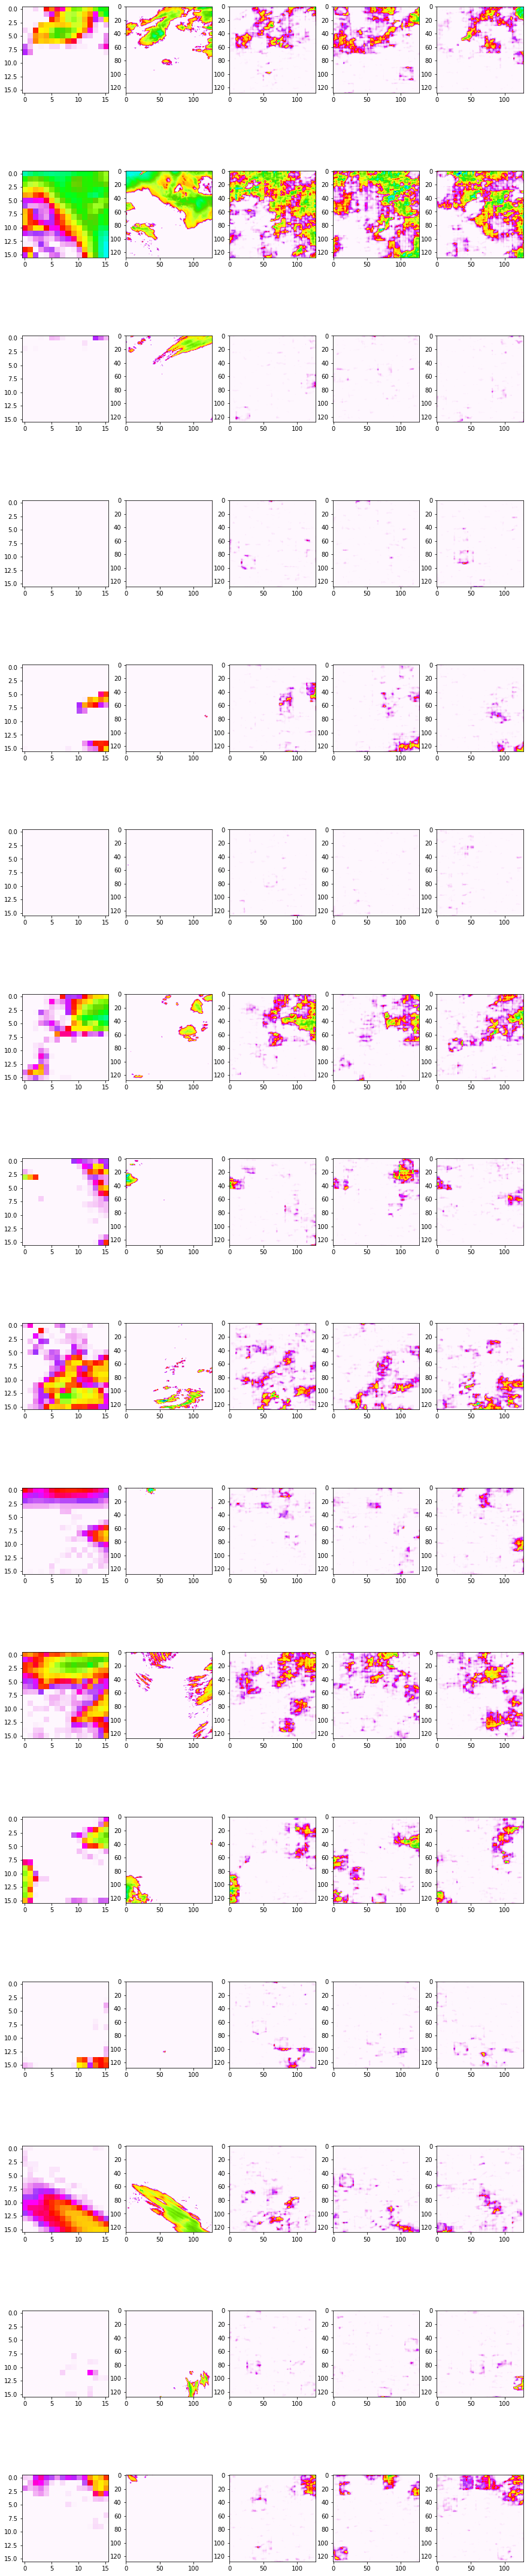

In [77]:
x_sample, y_sample = next(iter(dl_valid))
# noise = torch.randn(x_sample.shape[0], *model.noise_shape)
# plot_sample(noise, x_sample, y_sample, model.gen, k=16)
plot_samples_per_input(x_sample, y_sample, model.gen, k=16, device=device)

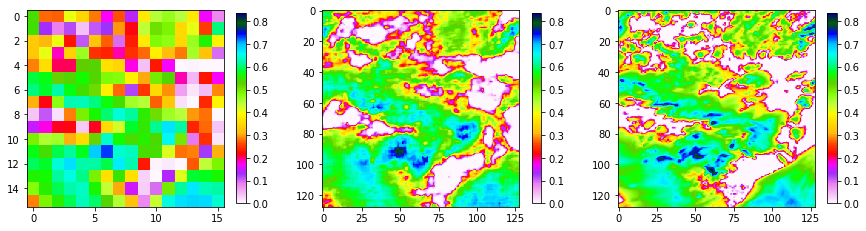

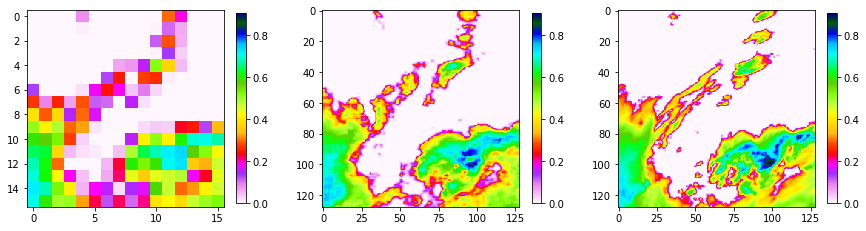

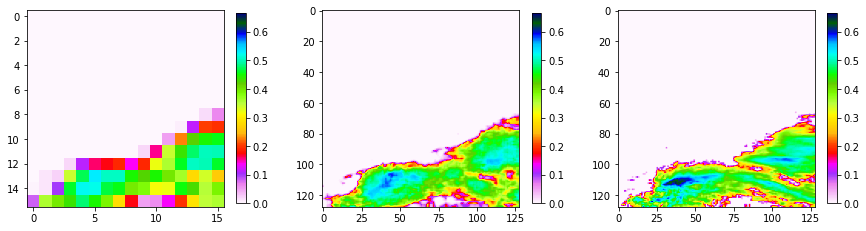

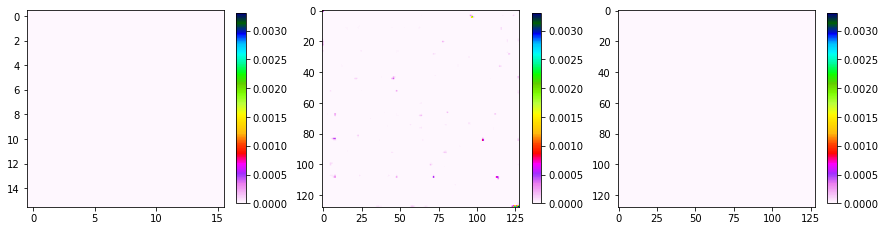

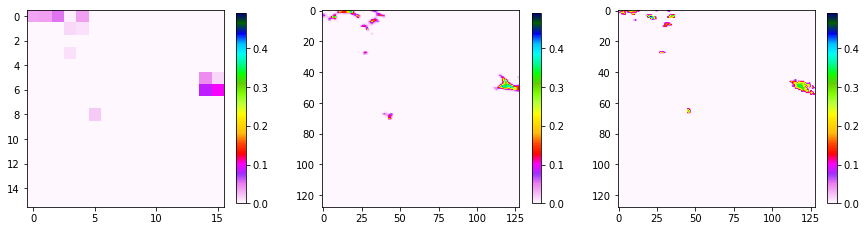

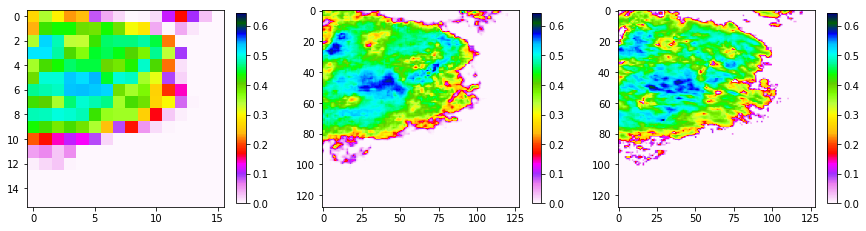

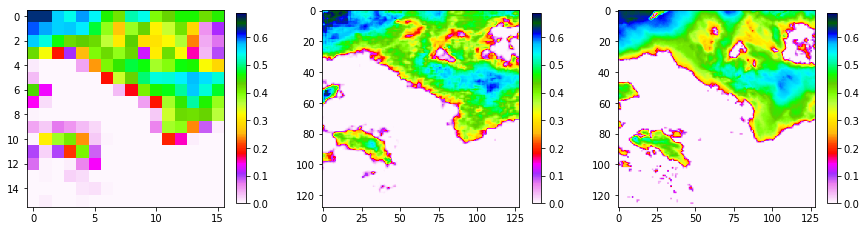

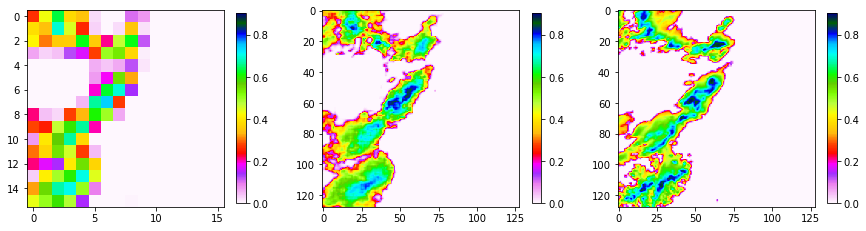

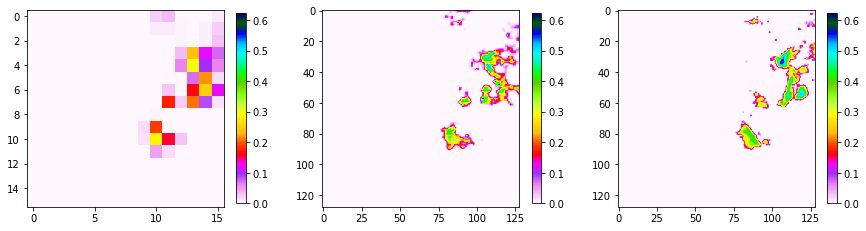

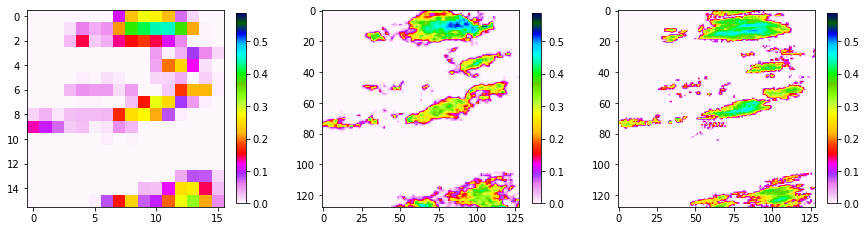

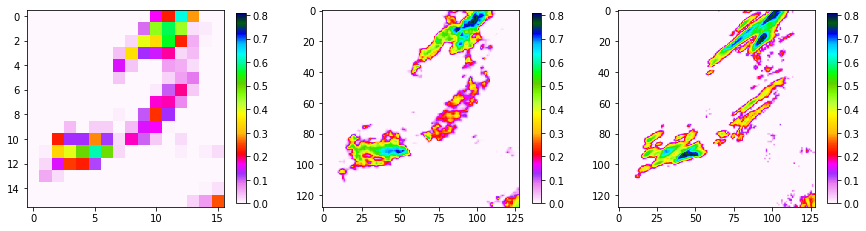

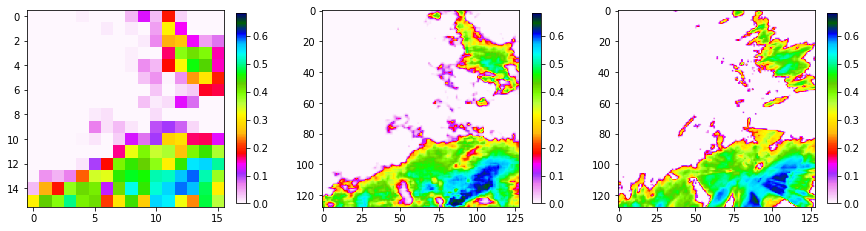

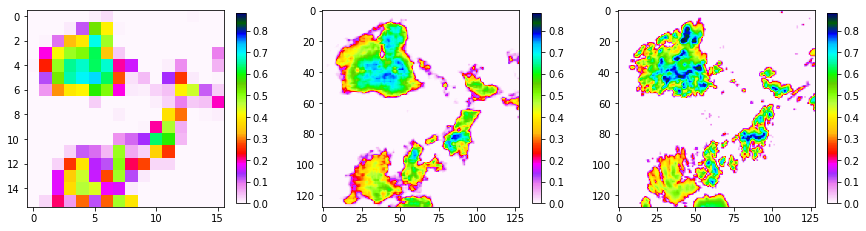

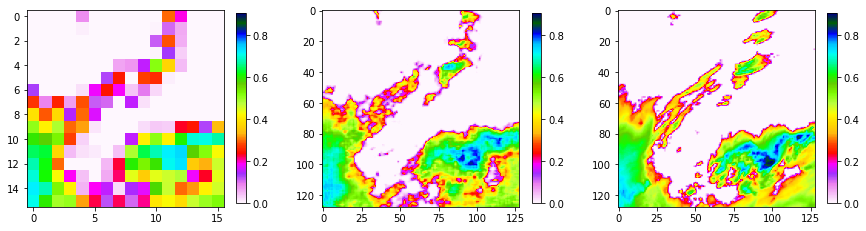

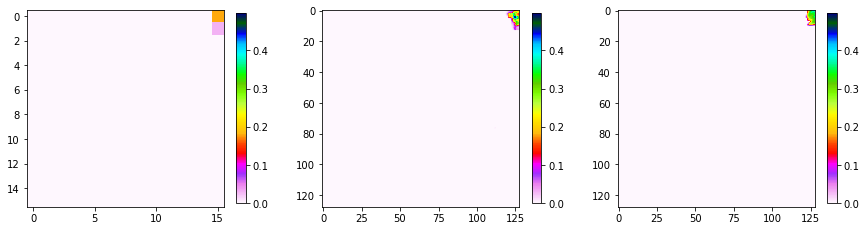

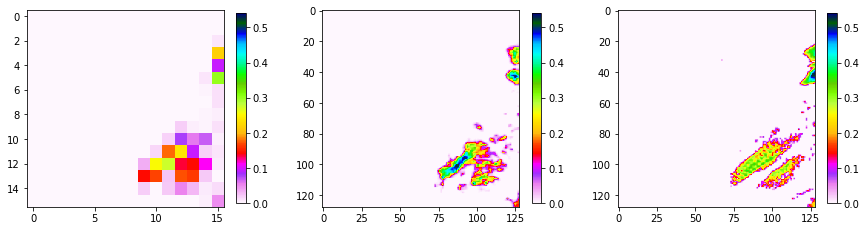

In [23]:
x_val_sample, y_val_sample = next(iter(dl_valid))
noise = torch.randn(x_val_sample.shape[0], *model.noise_shape)
plot_sample(noise, x_val_sample, y_val_sample, model.gen, k=16)

## LeinGan

In [15]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
import pytorch_lightning as pl

import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from ilan_src.models import *
import pickle

dl_train = pickle.load(open("./dataset/trainloader_single_forecast_only.pkl", "rb"))

LEARNING_RATE = 1e-4
IMG_SIZE = 128
CHANNELS_IMG = 1
NOISE_SHAPE = (1, 16, 16)
NUM_EPOCHS = 30
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10
NUM_CLASSES = 10
GEN_EMBEDDING = 10

trainer = pl.Trainer(gpus = 1, )
model = LeinGANGP(LeinGen, LeinDisc, 
                  NOISE_SHAPE, CHANNELS_IMG, 
                  IMG_SIZE, GEN_EMBEDDING, 
                  lr = LEARNING_RATE,
                  lambda_gp=LAMBDA_GP)

trainer.fit(model, dl_train)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type     | Params
----------------------------------
0 | gen  | LeinGen  | 4.2 M 
1 | disc | LeinDisc | 5.6 M 
----------------------------------
9.8 M     Trainable params
0         Non-trainable params
9.8 M     Total params
39.008    Total estimated model params size (MB)


Epoch 7:  57%|█████▋    | 751/1312 [08:06<06:03,  1.54it/s, loss=8.69, v_num=88, discriminator_loss_step=-3.96, generator_loss_step=115.0, discriminator_loss_epoch=-4.03, generator_loss_epoch=180.0]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 10:  67%|██████▋   | 877/1312 [09:28<04:41,  1.54it/s, loss=30.8, v_num=88, discriminator_loss_step=-9.17, generator_loss_step=284.0, discriminator_loss_epoch=-2.37, generator_loss_epoch=306.0]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 13:  89%|████████▉ | 1174/1312 [12:41<01:29,  1.54it/s, loss=16.5, v_num=88, discriminator_loss_step=1.570, generator_loss_step=160.0, discriminator_loss_epoch=-2.07, generator_loss_epoch=80.30]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 17:  14%|█▍        | 182/1312 [01:58<12:14,  1.54it/s, loss=7.26, v_num=88, discriminator_loss_step=-4.12, generator_loss_step=42.60, discriminator_loss_epoch=-2.07, generator_loss_epoch=60.60]    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 20:  36%|███▌      | 471/1312 [05:05<09:06,  1.54it/s, loss=16.4, v_num=88, discriminator_loss_step=0.961, generator_loss_step=47.30, discriminator_loss_epoch=-2.04, generator_loss_epoch=49.90]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 23:  61%|██████    | 795/1312 [08:35<05:35,  1.54it/s, loss=-2.88, v_num=88, discriminator_loss_step=-3.60, generator_loss_step=-59.3, discriminator_loss_epoch=-2.03, generator_loss_epoch=21.20]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 26:  76%|███████▌  | 991/1312 [10:41<03:27,  1.54it/s, loss=17.5, v_num=88, discriminator_loss_step=-1.57, generator_loss_step=37.90, discriminator_loss_epoch=-1.86, generator_loss_epoch=37.00]    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 29:  68%|██████▊   | 889/1312 [09:35<04:33,  1.55it/s, loss=3.49, v_num=88, discriminator_loss_step=-1.02, generator_loss_step=37.90, discriminator_loss_epoch=-1.67, generator_loss_epoch=43.90]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 32:  85%|████████▌ | 1116/1312 [12:02<02:06,  1.55it/s, loss=-0.0141, v_num=88, discriminator_loss_step=-.986, generator_loss_step=-16.2, discriminator_loss_epoch=-1.66, generator_loss_epoch=32.50] 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 35: 100%|█████████▉| 1306/1312 [14:06<00:03,  1.54it/s, loss=-1.24, v_num=88, discriminator_loss_step=-2.49, generator_loss_step=-6.03, discriminator_loss_epoch=-1.62, generator_loss_epoch=31.90]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 39:  15%|█▌        | 203/1312 [02:12<12:03,  1.53it/s, loss=-5.74, v_num=88, discriminator_loss_step=0.372, generator_loss_step=-11.4, discriminator_loss_epoch=-1.25, generator_loss_epoch=57.60]  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 42:   7%|▋         | 96/1312 [01:02<13:11,  1.54it/s, loss=4.07, v_num=88, discriminator_loss_step=-4.17, generator_loss_step=0.180, discriminator_loss_epoch=-1.42, generator_loss_epoch=38.90]      

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 45:  25%|██▍       | 324/1312 [03:30<10:40,  1.54it/s, loss=-3.29, v_num=88, discriminator_loss_step=-1.92, generator_loss_step=-33.2, discriminator_loss_epoch=-1.35, generator_loss_epoch=4.390]   

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch 48:  43%|████▎     | 560/1312 [06:02<08:06,  1.54it/s, loss=12.1, v_num=88, discriminator_loss_step=-4.67, generator_loss_step=-4.39, discriminator_loss_epoch=-1.38, generator_loss_epoch=1.080]    

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
trainer.save_checkpoint("./models/model-leingan-single-forecast-version-88.ckpt")

AssertionError: failed to inspect the obj init

In [20]:
pickle.dump(model, open("./models/model-leingan-single-forecast-version-88.pkl", "wb"))

In [21]:
dl_valid = pickle.load(open("./dataset/validloader_pure_sr.pkl", "rb"))

In [32]:
torch.save(model.gen.state_dict(), "./models/model-leingan-gen-single-forecast-version-88.m")

In [42]:
model.gen.load_state_dict(torch.load("./models/model-leingan-gen-single-forecast-version-88.m"))

<All keys matched successfully>

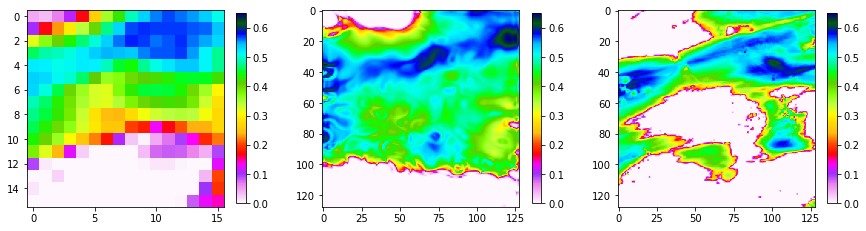

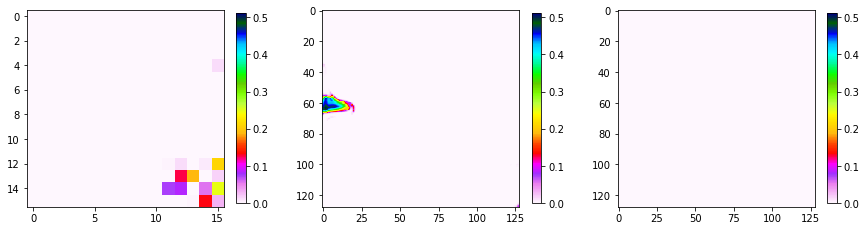

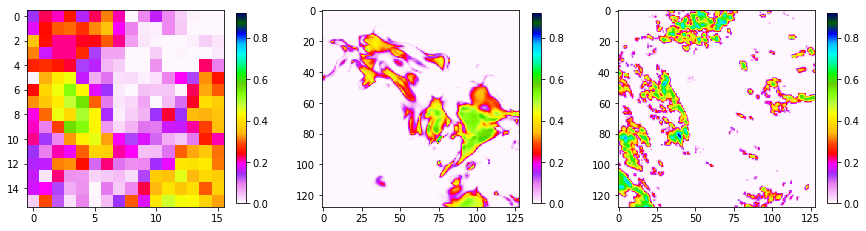

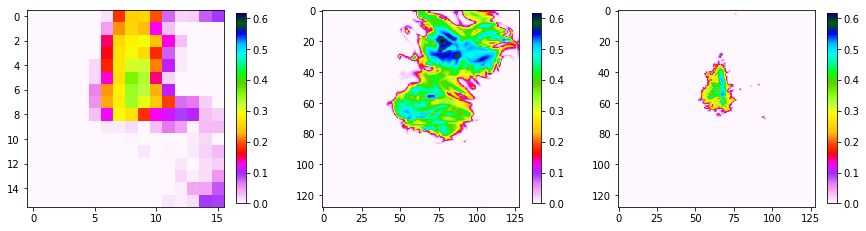

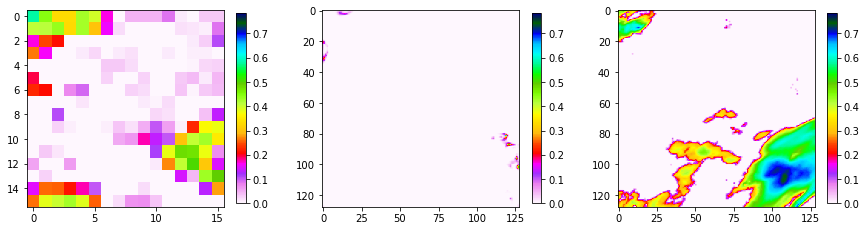

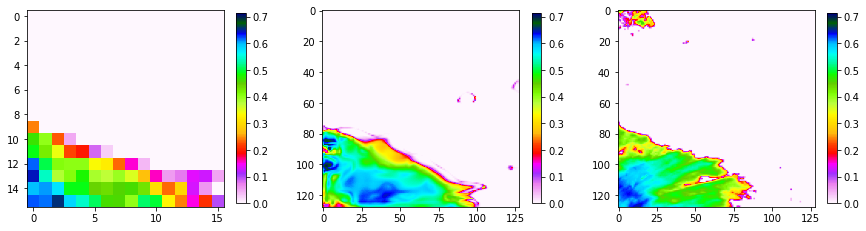

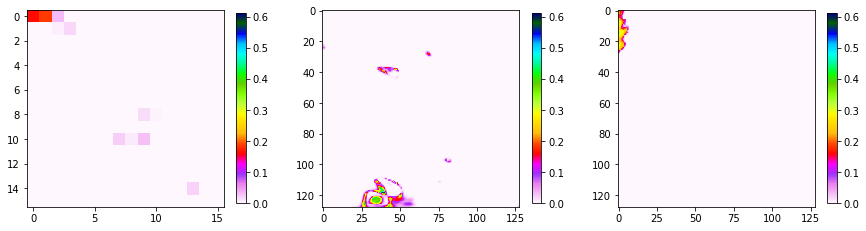

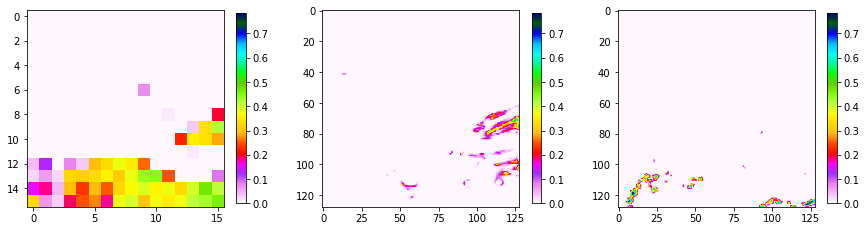

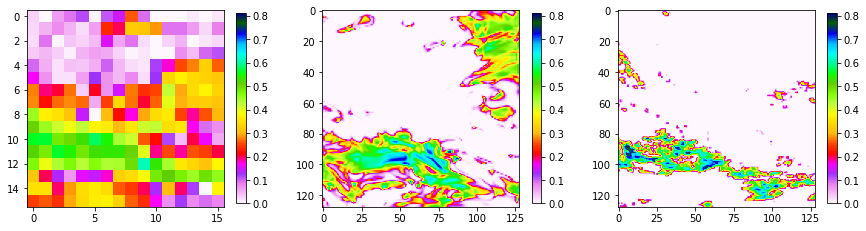

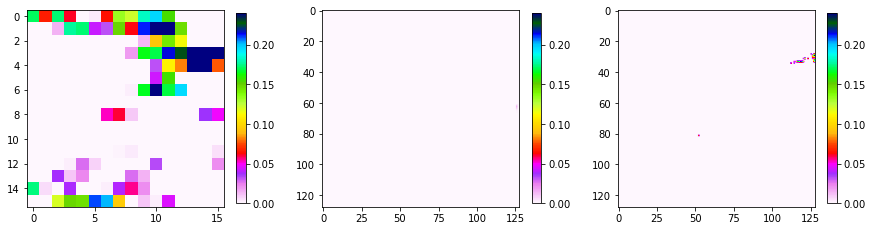

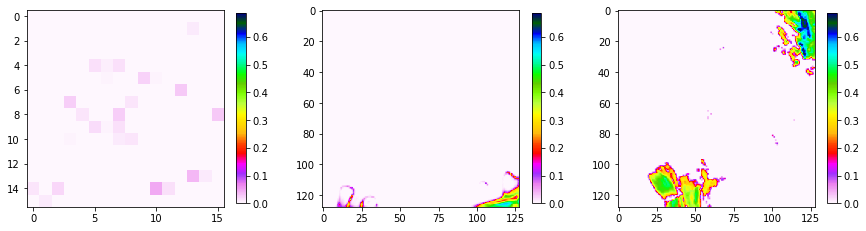

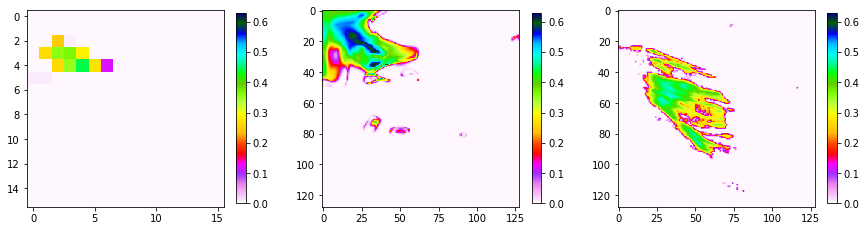

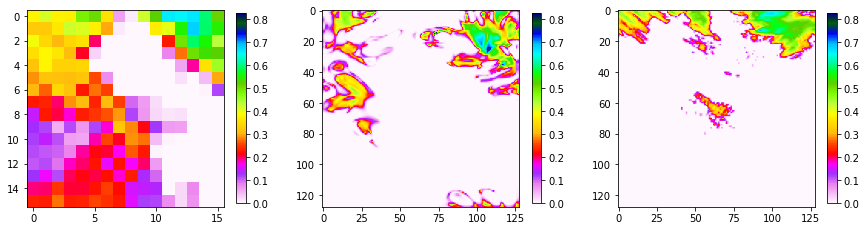

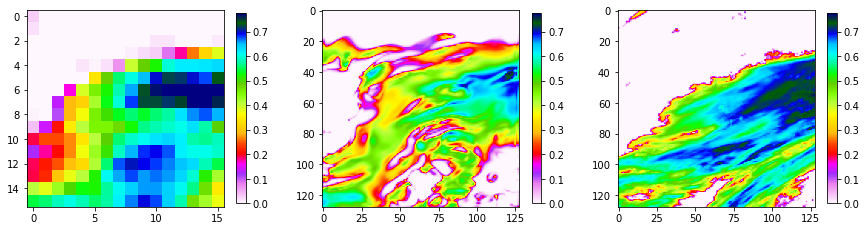

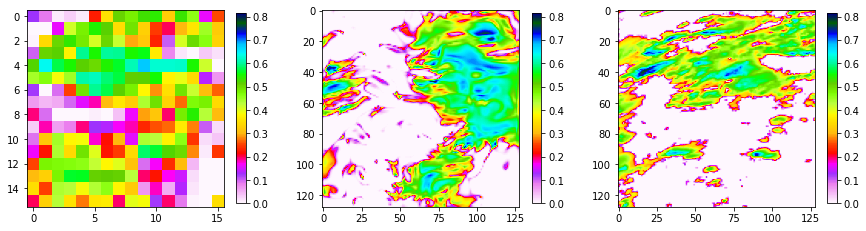

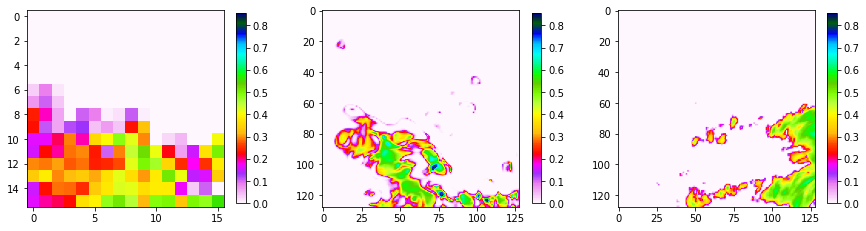

In [43]:
x_val_sample, y_val_sample = next(iter(dl_train))
# print(x_val_sample.shape)
noise = torch.randn(x_val_sample.shape[0], *model.noise_shape)
plot_sample(noise, x_val_sample, y_val_sample, model.gen, k=16)

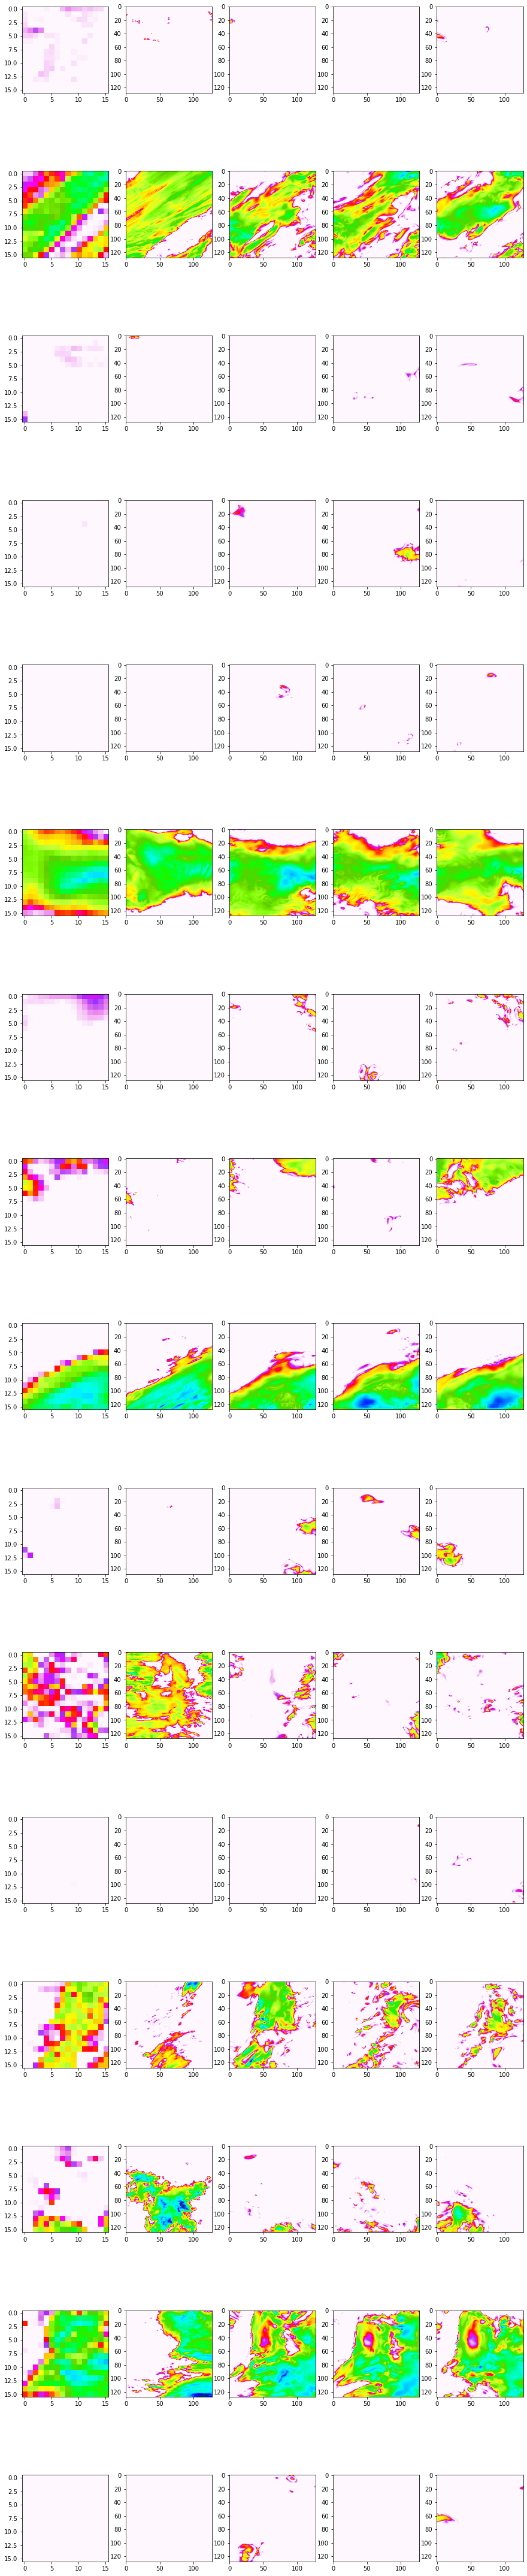

In [44]:
x_sample, y_sample = next(iter(dl_train))
# noise = torch.randn(x_sample.shape[0], *model.noise_shape)
# plot_sample(noise, x_sample, y_sample, model.gen, k=16)
plot_samples_per_input(x_sample, y_sample, model.gen, k=16)

In [112]:
out = g(x, noise)

In [113]:
out.shape

torch.Size([16, 1, 128, 128])

torch.Size([16, 1])

In [90]:
hin = 32
s = 1
p = 1
k = 4
d = 1

h = (hin-1)*s -2*p + d*(k-1) + 1
h

33

In [87]:
hin = 16
s = 2
p = 0
k = 1
d = 1

h = (hin-1)*s -2*p + d*(k-1) + 1
h

31